In [1]:
import numpy as np
import pandas as pd
import pyspark.sql.functions as F
import math
import sys
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import GBTRegressor, LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import Column, Window
from pyspark.sql.types import DoubleType
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
import matplotlib.pyplot as plt

In [3]:
APP_NAME = 'Taxi'
SPARK_URL = 'local[*]'

In [4]:
spark = SparkSession.builder.appName(APP_NAME).config('spark.ui.showConsoleProgress', 'false').getOrCreate()

#### Data overview

Data loading:

In [5]:
taxi_2022 = spark.read.csv('Taxi_Trips_-_2022.csv', header='true', inferSchema = 'true')

In [6]:
taxi_2023 = spark.read.csv('Taxi_Trips_-_2023.csv', header='true', inferSchema = 'true')

Data Schema overview:

In [7]:
taxi_2022.printSchema()

root
 |-- Trip ID: string (nullable = true)
 |-- Taxi ID: string (nullable = true)
 |-- Trip Start Timestamp: string (nullable = true)
 |-- Trip End Timestamp: string (nullable = true)
 |-- Trip Seconds: integer (nullable = true)
 |-- Trip Miles: double (nullable = true)
 |-- Pickup Census Tract: long (nullable = true)
 |-- Dropoff Census Tract: long (nullable = true)
 |-- Pickup Community Area: integer (nullable = true)
 |-- Dropoff Community Area: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Tips: double (nullable = true)
 |-- Tolls: double (nullable = true)
 |-- Extras: double (nullable = true)
 |-- Trip Total: double (nullable = true)
 |-- Payment Type: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Pickup Centroid Latitude: double (nullable = true)
 |-- Pickup Centroid Longitude: double (nullable = true)
 |-- Pickup Centroid Location: string (nullable = true)
 |-- Dropoff Centroid Latitude: double (nullable = true)
 |-- Dropoff Centroid 

In [8]:
taxi_2023[['Trip ID',
 'Taxi ID',
 'Trip Start Timestamp',
 'Trip End Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Community Area',]].describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+------------------+----------------+---------------------+
|summary|             Trip ID|             Taxi ID|Trip Start Timestamp|  Trip End Timestamp|      Trip Seconds|      Trip Miles|Pickup Community Area|
+-------+--------------------+--------------------+--------------------+--------------------+------------------+----------------+---------------------+
|  count|             3783730|             3783730|             3783730|             3783682|           3783012|         3783717|              3615963|
|   mean|                null|                null|                null|                null|1235.3278387697421|6.47123319476644|    35.03091652209937|
| stddev|                null|                null|                null|                null|1736.5661018295136|7.59331044121222|   26.078720147019546|
|    min|0000012deb83dbb55...|00110971c7c4a7173...|01/01/2023 01:00:...|01/01/2023 01:00

In [9]:
taxi_2022[['Trip ID',
 'Taxi ID',
 'Trip Start Timestamp',
 'Trip End Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Community Area',]].describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+------------------+-----------------+---------------------+
|summary|             Trip ID|             Taxi ID|Trip Start Timestamp|  Trip End Timestamp|      Trip Seconds|       Trip Miles|Pickup Community Area|
+-------+--------------------+--------------------+--------------------+--------------------+------------------+-----------------+---------------------+
|  count|             6382425|             6382425|             6382425|             6382213|           6380960|          6382369|              5868572|
|   mean|                null|                null|                null|                null|1198.2085212883328|6.185568905527588|    32.35048253646713|
| stddev|                null|                null|                null|                null| 1895.664878082732|   8.002858369488|   25.203045304909356|
|    min|000000bb18f0563c1...|0041f8f0c91881c1e...|01/01/2022 01:00:...|01/01/2022

In [10]:
taxi_2022[['Pickup Community Area']].describe().show()

+-------+---------------------+
|summary|Pickup Community Area|
+-------+---------------------+
|  count|              5868572|
|   mean|    32.35048253646713|
| stddev|   25.203045304909356|
|    min|                    1|
|    max|                   77|
+-------+---------------------+



In [11]:
taxi_2022[['Fare',
 'Tips',
 'Tolls',
 'Extras',
 'Trip Total']].describe().show()

+-------+------------------+------------------+-------------------+-----------------+------------------+
|summary|              Fare|              Tips|              Tolls|           Extras|        Trip Total|
+-------+------------------+------------------+-------------------+-----------------+------------------+
|  count|           6378889|           6378889|            6378889|          6378889|           6378889|
|   mean| 21.72931312020104|2.7545550142038486|0.02128382074057096|2.163035586604502| 26.82509761809589|
| stddev|49.416238999460845|  4.08389167014634|  7.659938846744798|21.75269211485504|56.964604407228194|
|    min|               0.0|               0.0|                0.0|              0.0|               0.0|
|    max|           9999.75|             496.0|            6666.66|          8888.88|           9999.75|
+-------+------------------+------------------+-------------------+-----------------+------------------+



Choosing features for taxi count calculation for every moment in time for both 2022 и 2023. We don't need information about dropoffs, trip ending timestamp and about census tract.

In [12]:
taxi_2022 = taxi_2022.select(
 'Trip Start Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Community Area',
 'Fare',
 'Tips',
 'Tolls',
 'Extras',
 'Trip Total',
 'Pickup Centroid Latitude',
 'Pickup Centroid Longitude',
 'Dropoff Centroid Latitude',
 'Dropoff Centroid Longitude'
)


In [13]:
taxi_2023 = taxi_2023.select(
 'Trip Start Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Community Area',
 'Fare',
 'Tips',
 'Tolls',
 'Extras',
 'Trip Total',
 'Pickup Centroid Latitude',
 'Pickup Centroid Longitude',
 'Dropoff Centroid Latitude',
 'Dropoff Centroid Longitude'
)


## Missing Data

In [14]:
def percentage_missings(df):
    nan_df = df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in df.dtypes if c_type not in ('timestamp', 'string', 'date')]).toPandas()
    nan_df = nan_df/df.count()
    return nan_df

In [15]:
def plot_missings(df):
    nan = percentage_missings(df)
    nan.plot.bar(figsize=(12,8))

In [16]:
def fill_na_with_previos(data):
    columns = data.columns
    columns.remove('Pickup Community Area')
    columns.remove('Trip Start Timestamp')
    
    for column in columns:
        window = Window.partitionBy('Pickup Community Area')\
                       .orderBy('Trip Start Timestamp')\
                       .rowsBetween(-sys.maxsize, 0)
        filled_column = F.last(column, ignorenulls=True).over(window)
        data = data.withColumn(column, filled_column)
    return data

In [17]:
def fill_na_with_mean(data):
    for column in data.columns:
        window = Window.partitionBy('Pickup Community Area')\
                       .orderBy('Trip Start Timestamp')\
                       .rowsBetween(-sys.maxsize, 0)
        filled_column = F.mean(column).over(window)
        data = data.withColumn(column, filled_column)
    
    return data
    
def fill_na_with_mean(data): 
    imputer = Imputer(
    inputCols=data.columns, 
    outputCols=["{}_imputed".format(c) for c in data.columns]
    )
    imputer.fit(data).transform(data)

We wil calculate percentage of missings for 2022 and 2023 and plot them:

#### 2022

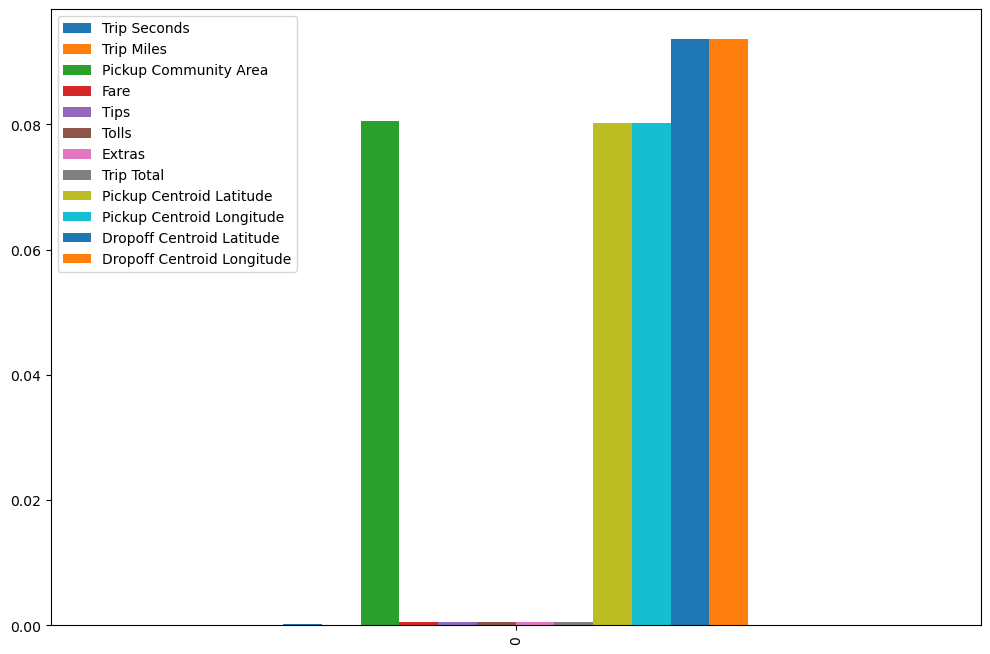

In [18]:
plot_missings(taxi_2022)

Removing objects with empty area values, as they are the source of our target variables:

In [19]:
taxi_2022 = taxi_2022.filter(taxi_2022['Pickup Community Area'].isNotNull())

Other missing we will fill with previos value in time for each area:

In [20]:
taxi_2022 = fill_na_with_previos(taxi_2022)

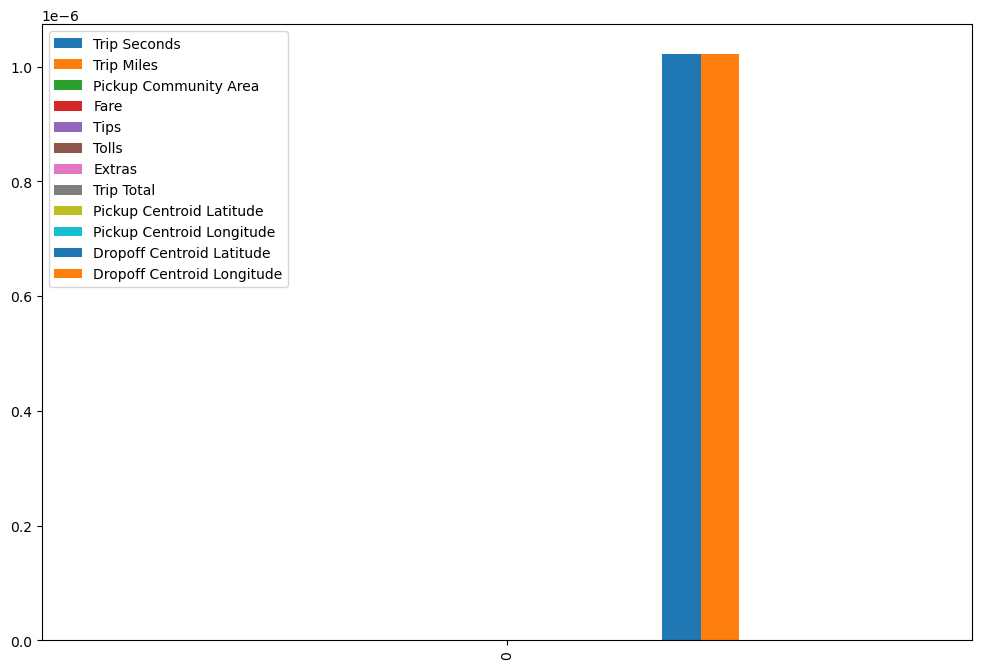

In [21]:
plot_missings(taxi_2022)

#### 2023

Similar for 2023:

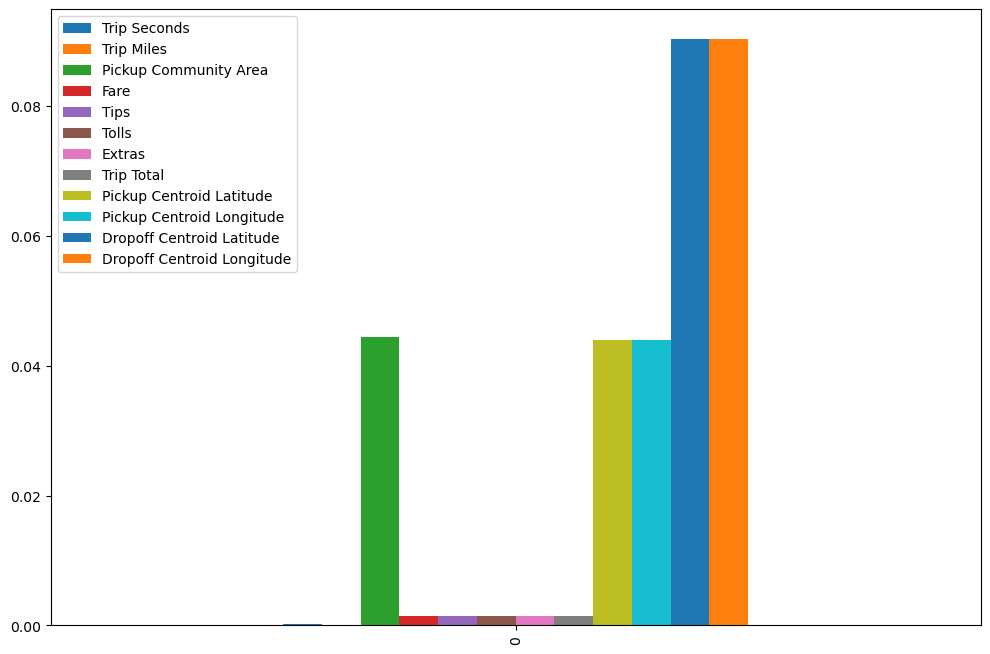

In [22]:
plot_missings(taxi_2023)

In [23]:
taxi_2023 = taxi_2023.filter(taxi_2023['Pickup Community Area'].isNotNull())

In [24]:
taxi_2023 = fill_na_with_previos(taxi_2023)


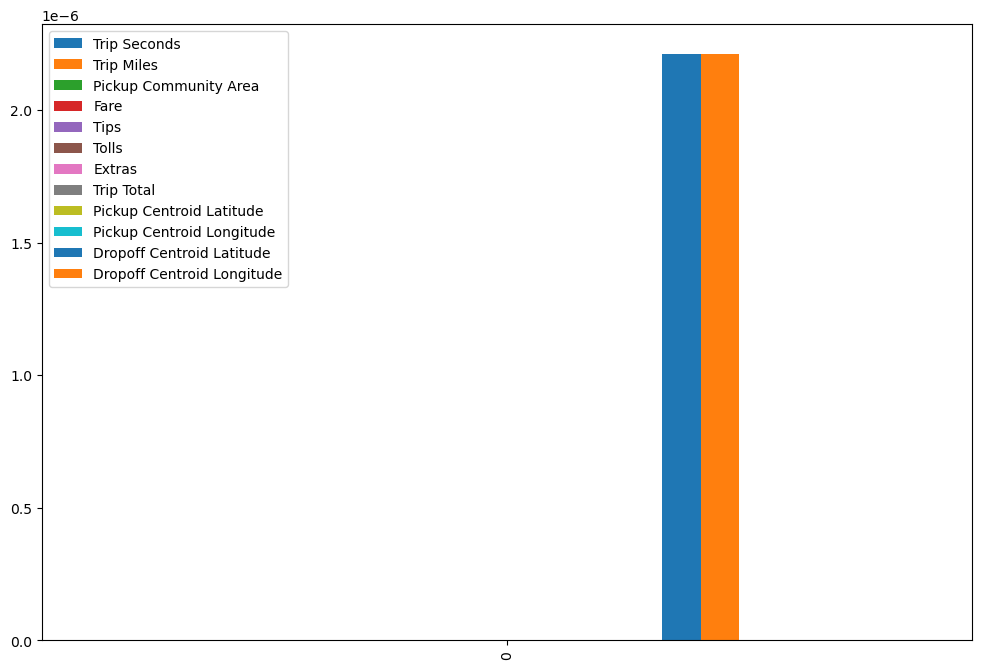

In [25]:
plot_missings(taxi_2023)

#### Merging dataframes

Merging data for both years into one dataframe:

In [26]:
taxi = taxi_2022.union(taxi_2023)
#taxi.show()

### Direct Distance between pickup and dropoff

Calculating distance between pickup and dropoff coordinates. If coords are empty, fill them with 0:

In [27]:
def calculate_distance(start_latitude, start_longitude, end_latitude, end_longitude):
    try:
        dist = math.dist((start_latitude, start_longitude), (end_latitude, end_longitude))
    except:
        dist = 0
    return dist

In [28]:
calculate_distance_udf = F.udf(calculate_distance, DoubleType())

In [29]:
taxi = taxi.withColumn('direct_distance', F.lit(calculate_distance_udf(
    'Pickup Centroid Latitude',
    'Pickup Centroid Longitude',
    'Dropoff Centroid Latitude', 
    'Dropoff Centroid Longitude')))

In [30]:
taxi = taxi.drop('Pickup Centroid Latitude',
    'Pickup Centroid Longitude',
    'Dropoff Centroid Latitude',
    'Dropoff Centroid Longitude')

### Transforming Data

Now let's transform date columns to timestamp type:

In [31]:
taxi = taxi.withColumn('trip_date', F.to_timestamp(taxi['Trip Start Timestamp'], 'MM/dd/yyyy hh:mm:ss a')).drop('Trip Start Timestamp')
taxi = taxi.withColumn('trip_date', F.date_trunc('hour', taxi['trip_date']))

Also create taxi_count property for grouping the data:

In [32]:
taxi = taxi.withColumn('taxi_count', F.lit(1))

Grouping data by date and area:

In [33]:
taxi_transformed = taxi.groupby(['trip_date','Pickup Community Area']).agg({
    'Trip Seconds':'mean', 
    'Trip Miles': 'mean', 
    'taxi_count':'count',
    'Fare':'mean',
    'Tips':'mean',
    'Tolls':'mean',
    'Extras':'mean',
    'Trip Total':'mean',
    'direct_distance':'mean'}).orderBy(['trip_date','Pickup Community Area'])
taxi_transformed.show()

+-------------------+---------------------+------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+--------------------+----------+
|          trip_date|Pickup Community Area|   avg(Trip Total)|count(taxi_count)| avg(Trip Seconds)|         avg(Tips)|        avg(Extras)|   avg(Trip Miles)|         avg(Fare)|avg(direct_distance)|avg(Tolls)|
+-------------------+---------------------+------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+--------------------+----------+
|2022-01-01 00:00:00|                    1|              37.5|                1|            3073.0|               0.0|                1.0|             10.85|              36.5|0.046081936759981755|       0.0|
|2022-01-01 00:00:00|                    2|12.166666666666666|                3| 632.6666666666666|               0.0|                0.0| 3.436666666666667|       

## Seasonality

Let's decompose data into trend and seasonality:

In [34]:
days = 60 * 60 * 24
seasonal_data = taxi_transformed[['trip_date','count(taxi_count)']].groupBy('trip_date').agg({'count(taxi_count)' : 'mean'}).orderBy('trip_date')
w = Window.orderBy(F.col('trip_date').cast('long')).rangeBetween(-days, 0)
seasonal_data = seasonal_data.withColumn('rolling_mean', F.avg('avg(count(taxi_count))').over(w))

#decomposed = seasonal_decompose(seasonal_data.toPandas()['trip_date'])
#decomposed.seasonal['2022-01':'2022-02'].plot(ax=plt.gca())

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


<Axes: xlabel='trip_date'>

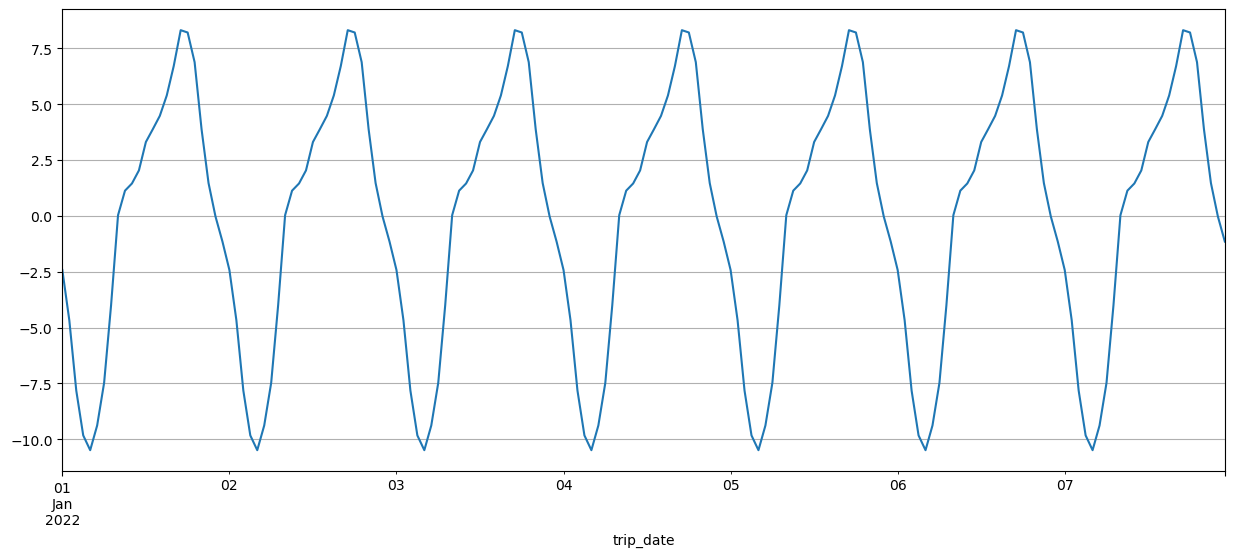

In [35]:
seasonal_p = seasonal_data.toPandas()
seasonal_p = seasonal_p.set_index('trip_date')
seasonal_p = seasonal_p.asfreq('H')
#seasonal_p.index.freq = 'H'
seasonal_p = seasonal_p.fillna(0)
decomposed = seasonal_decompose(seasonal_p['avg(count(taxi_count))'])
decomposed.seasonal['2022-01-01':'2022-01-07'].plot(ax=plt.gca(), figsize = (15,6), grid=True)

Seasonality is daily.

<Axes: xlabel='trip_date'>

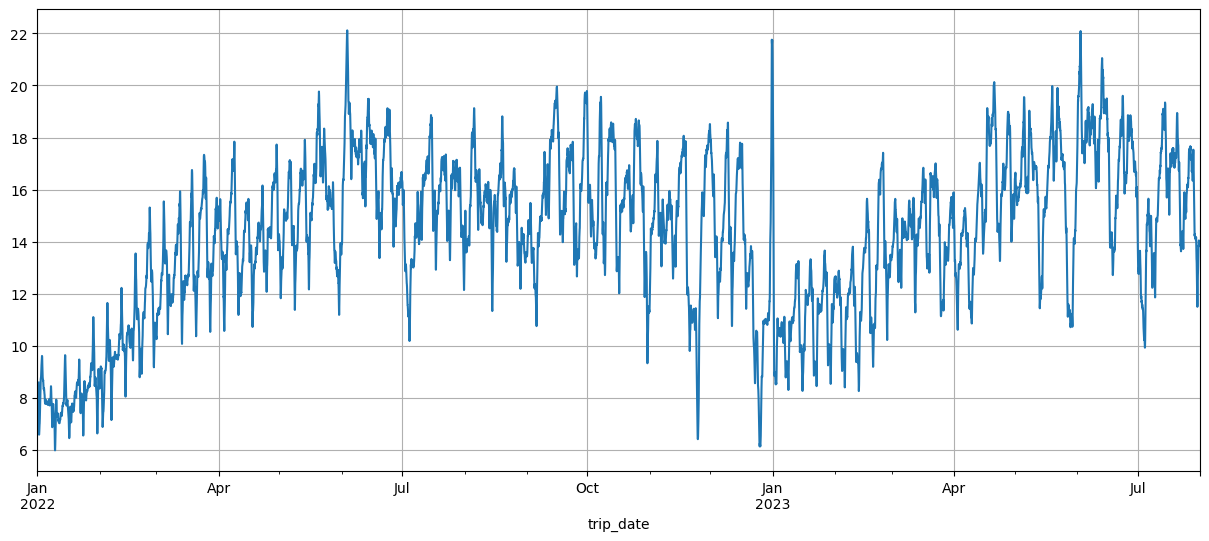

In [36]:
decomposed.trend.plot(ax=plt.gca(), figsize = (15,6), grid=True)

Trend is increasing to the end of year. Trend curve of 2023 is similar to 2022

In [37]:
def get_time_series_per_every_area(taxi_transformed, area_count, template_dates):
    areas = []
    for i in range(1, area_count+1):
        area_data = taxi_transformed.filter(taxi_transformed['Pickup Community Area'] == i).drop('Pickup Community Area')
        joined_data = template_dates
        joined_data = joined_data.join(area_data, joined_data.date == area_data.trip_date, 'left')
        joined_data = joined_data.drop('trip_date').na.fill(0)
        areas.append(joined_data.orderBy('date'))
    return areas

In [38]:
def get_time_series_per_selected_areas(taxi_transformed, areas_nums, template_dates):
    areas = []
    for i in areas_nums:
        area_data = taxi_transformed.filter(taxi_transformed['Pickup Community Area'] == i).drop('Pickup Community Area')
        joined_data = template_dates
        joined_data = joined_data.join(area_data, joined_data.date == area_data.trip_date, 'left')
        joined_data = joined_data.drop('trip_date').na.fill(0)
        areas.append(joined_data.orderBy('date'))
    return areas

In [39]:
def generate_time_series(start, stop, interval):
    start, stop = spark.createDataFrame(
        [(start, stop)], ('start', 'stop')).select(
        [F.col(c).cast('timestamp').cast('long') for c in ('start', 'stop')]).first()
    return spark.range(start, stop, interval).select(
        F.col('id').cast('timestamp').alias('date'))

Calculating template time series for every hour in the period:

In [40]:
template = generate_time_series('2022-01-01', '2023-08-01', 3600)

Get highest taxi count areas. For them we will tune hyperparameters because they are the most important values for us because they will have highest mae:

In [41]:
def get_highest_taxi_count_areas(data, count):
    data = data.groupby('Pickup Community Area').agg({
        'taxi_count':'count'}).orderBy('count(taxi_count)', ascending=False)
    return data.take(5)

In [42]:
highest_count_areas = get_highest_taxi_count_areas(taxi, 5)
highest_count_areas

[Row(Pickup Community Area=8, count(taxi_count)=2296037),
 Row(Pickup Community Area=76, count(taxi_count)=1736750),
 Row(Pickup Community Area=32, count(taxi_count)=1641487),
 Row(Pickup Community Area=28, count(taxi_count)=873134),
 Row(Pickup Community Area=33, count(taxi_count)=377712)]

In [60]:
highest_count_areas = [8, 32, 76, 28, 33]

And get an array with data for every area: 

In [44]:
time_series_datas = get_time_series_per_every_area(taxi_transformed, 77, template)

### Feature Engineering

### Training

In [45]:
def extract_month_week_day(dataset, date_col):
    return dataset.withColumn('year', F.year(dataset[date_col])) \
    .withColumn('month', F.month(dataset[date_col])) \
    .withColumn('week', F.weekofyear(dataset[date_col])) \
    .withColumn('dow', F.dayofweek(dataset[date_col])) \
    .withColumn('day', F.dayofmonth(dataset[date_col])) \
    .withColumn('hour', F.hour(dataset[date_col])) \
    .withColumn('minute', F.minute(dataset[date_col]))

In [46]:
def create_lag(dataframe, size, step):
    w = Window.orderBy('date')
    

    for i in range(1, size, step):
        dataframe = dataframe.withColumn('lag'+str(i), F.lag('count(taxi_count)', i).over(w))
    return dataframe.dropna(how='any')

In [47]:
def add_rolling_mean(dataframe, size):
    days = 60*60*size
    w = Window.orderBy(F.col('date').cast('long')).rangeBetween(-days, 0)
    dataframe = dataframe.withColumn('rolling_mean', F.avg('count(taxi_count)').over(w))
    return dataframe

In [48]:
def create_features(data):
    data = extract_month_week_day(data, 'date')
    data = create_lag(data, 24, 1)
    data = add_rolling_mean(data, 6)
    return data

In [49]:
def train_valid_split(data, percentage):

    data = data.withColumn('rank', F.percent_rank().over(Window.partitionBy().orderBy('date')))
    return data.filter(data['rank'] < percentage).drop('rank'), data.filter(data['rank'] >= percentage).drop('rank')

In [50]:
def prepare_data(train, test, features):
    va = VectorAssembler(inputCols = features, outputCol = 'features')

    train_va = va.transform(train)
    train_va = train_va.select(['features', 'count(taxi_count)'])
    test_va = va.transform(test)
    test_va = test_va.select(['features', 'count(taxi_count)'])

    standardScaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=True)
    model = standardScaler.fit(train_va)
    train_va = model.transform(train_va)
    train_va = train_va.withColumn('features', train_va['scaledFeatures']).drop('scaledFeatures')
    test_va = model.transform(test_va)
    test_va = test_va.withColumn('features', test_va['scaledFeatures']).drop('scaledFeatures')

    return train_va, test_va

Tuning hyperparameters for highest taxi count areas:

In [51]:
def tuning(datas_list, max_depth, max_iter):
    #data = data.orderby('count(taxi_count)').filter(data['count(taxi_count)'])


    best_model = GBTRegressor(labelCol='count(taxi_count)')
    best_mae = 50
    for m_d in max_depth:
        for m_i in max_iter:
            mae_list = []
            for data in datas_list:
                data = create_features(data)
    
                features = data.columns
                features.remove('count(taxi_count)')
                features.remove('date')
                label = 'count(taxi_count)'
                
                #row_div = 24 * 356 * 0.9
                #partition=Window.partitionBy('date').orderBy('date')
                #data = data.withColumn('row', F.row_number().over(Window.partitionBy().orderBy('date')))
                train, valid = train_valid_split(data, 0.75)

                train_va, valid_va = prepare_data(train, valid, features)
                
                model = GBTRegressor(labelCol='count(taxi_count)', maxDepth = m_d, maxIter=m_i)
                gbtc = model.fit(train_va)
    
                pred = gbtc.transform(valid_va)
    
                evaluator = RegressionEvaluator(metricName='mae', labelCol='count(taxi_count)')
                mae_list.append(evaluator.evaluate(pred))
            mae = np.mean(mae_list)
            if mae < best_mae:
                best_model = model
                best_mae = mae
    return best_model, best_mae

In [61]:
highest_count_time_series = get_time_series_per_selected_areas(taxi_transformed.filter(taxi_transformed['trip_date'] < '2023-01-01'), highest_count_areas, template)

In [62]:
best_model, best_mae = tuning(highest_count_time_series, [5, 7], [20, 40])

Best mae on highest count data tuning:

In [63]:
best_mae

0.04403398581883725

Best model:

In [55]:
best_model

GBTRegressor_24cd465c0794

In [56]:
def training(data, best_model):
    data = create_features(data)
    features = data.columns
    features.remove('count(taxi_count)')
    features.remove('date')
    label = 'count(taxi_count)'

    train = data.filter(data.year == 2022).orderBy('date')
    test = data.filter(data.year == 2023).orderBy('date')

    train_va, test_va = prepare_data(train, test, features)

    best_model = best_model.fit(train_va)
    pred = best_model.transform(test_va)

    evaluator = RegressionEvaluator(metricName='mae', labelCol='count(taxi_count)')
    mae = evaluator.evaluate(pred)

    return mae

In [57]:
%%time
mae=[]

for data in time_series_datas:
    mae.append(training(data, best_model))

mae

CPU times: user 5.77 s, sys: 3.15 s, total: 8.91 s
Wall time: 48min 57s


[1.1857246734962699,
 1.505084882747495,
 2.582413118026066,
 0.8720963080088797,
 0.7004150340251443,
 5.817502049359749,
 3.9287102446909214,
 18.538381007969196,
 0.028245499182963523,
 0.564267939924628,
 0.3490801693998315,
 0.32571155678854186,
 0.3233413647246476,
 0.4690793735477338,
 0.43091665611326907,
 1.1056889002801615,
 0.08574412581093185,
 0.01053063377363101,
 0.17092320062634775,
 0.021520763864671905,
 0.5264246021783682,
 1.1028574046952544,
 0.20237748096820218,
 2.192160172907399,
 0.5038991908393092,
 0.08550472176795974,
 0.19442785314375244,
 10.606740330203317,
 0.17547093920442228,
 0.1185982475699964,
 0.35172060911619274,
 15.667898129172613,
 6.349752550500776,
 0.6501162933533693,
 1.1311899509527112,
 0.49141081858817265,
 0.4134378928878794,
 1.0094178164568777,
 0.8695718844528743,
 0.29778234604154835,
 1.3437547405192571,
 0.6883878654345199,
 1.0608497055450834,
 1.021245774755331,
 0.1759747796818423,
 0.397043208739124,
 0.05681607015729914,
 0.2

In [58]:
np.mean(mae)

1.624466456917663

### Final Mae

Test mae for whole dataset:

In [59]:
np.mean(mae)

1.624466456917663